In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [2]:
adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Concatenate_T_cell.h5ad")

In [3]:
adata.raw = adata

In [4]:
adata2 = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

In [5]:
adata2.X.shape

(79567, 18933)

In [6]:
adata2.raw =  adata2

In [7]:
sc.pp.calculate_qc_metrics(adata2, inplace=True)

In [8]:
# Also calculate percent malat1
ribo_genes = adata2.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata2.obs['percent_ribo'] = np.sum(
    adata2[:, ribo_genes].X, axis=1) / np.sum(adata2.X, axis=1)

98


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
mito_genes = adata2.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata2.obs['percent_mito'] = np.sum(
    adata2[:, mito_genes].X, axis=1) / np.sum(adata2.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata2.obs['n_counts'] = adata2.X.sum(axis=1)

print(sum(mito_genes))

13


In [10]:
# Also calculate percent malat1
ribo_genes = adata2.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata2.obs['percent_ribo'] = np.sum(
    adata2[:, ribo_genes].X, axis=1) / np.sum(adata2.X, axis=1)


98


In [11]:
del adata

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


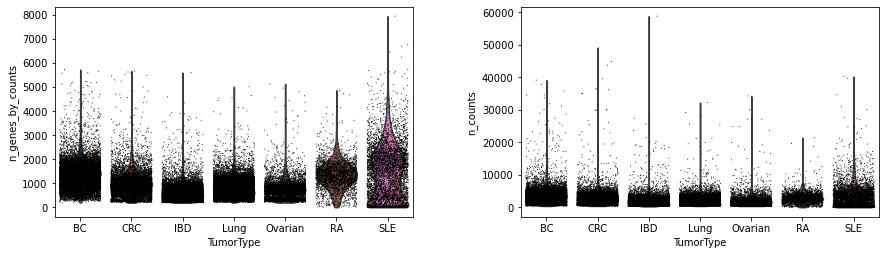

In [12]:
sc.pl.violin(adata2, ['n_genes_by_counts', 'n_counts'],
             jitter=0.4, groupby = 'TumorType')

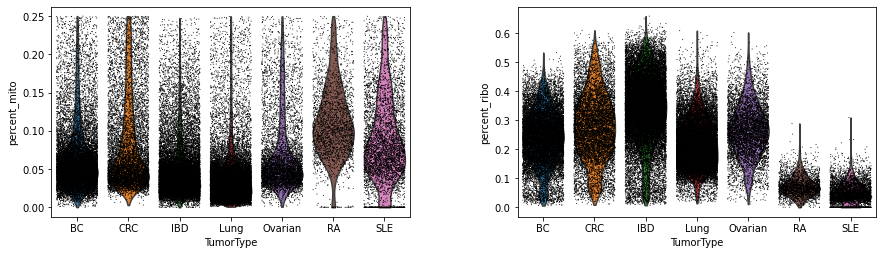

In [13]:
sc.pl.violin(adata2, ['percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'TumorType')

In [14]:
print('Total number of cells: {:d}'.format(adata2.n_obs))
adata2 = adata2[adata2.obs['percent_mito'] < 0.25]
print('Number of cells after MT filter: {:d}'.format(adata2.n_obs))

Total number of cells: 79567


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after MT filter: 79567


In [15]:
print('Total number of cells: {:d}'.format(adata2.n_obs))
adata2 = adata2[adata2.obs['n_counts'] > 500]
print('Number of cells after low counts filter: {:d}'.format(adata2.n_obs))

Total number of cells: 79567


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after low counts filter: 75148


In [16]:
print('Total number of cells: {:d}'.format(adata2.n_obs))
adata2 = adata2[adata2.obs['n_counts'] < 10000]
print('Number of cells after high counts filter: {:d}'.format(adata2.n_obs))

Total number of cells: 75148


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after high counts filter: 74572


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


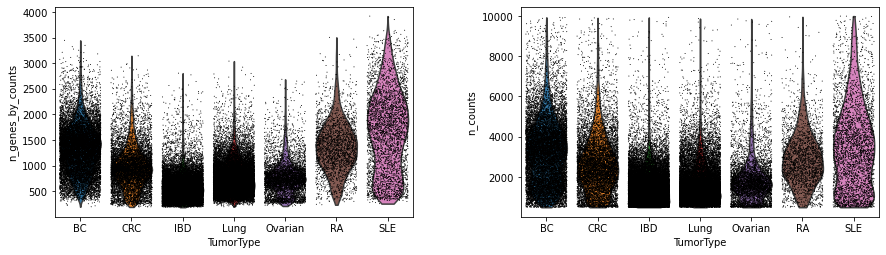

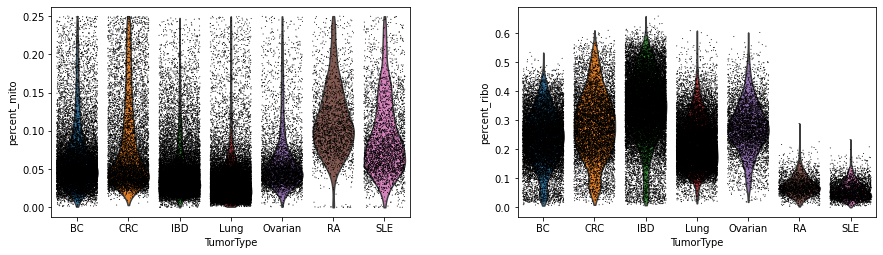

In [17]:
sc.pl.violin(adata2, ['n_genes_by_counts', 'n_counts'],
             jitter=0.4, groupby = 'TumorType')
sc.pl.violin(adata2, ['percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'TumorType')

In [18]:
# split per batch into new objects.
batches = ['RA','SLE','BC','CRC','Lung','Ovarian','IBD']
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['TumorType'] == batch,]

In [19]:
for dat in alldata:
    sc.pp.normalize_per_cell(alldata[dat], counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of vi

In [20]:
alldata['RA'].obs['dataset'] = "CellSeq"
alldata['SLE'].obs['dataset'] = "CellSeq"
alldata['IBD'].obs['dataset'] = "10X 3 V2"
alldata['CRC'].obs['dataset'] = "10X 3 V2"
alldata['Lung'].obs['dataset'] = "10X 3 V2"
alldata['Ovarian'].obs['dataset'] = "10X 3 V2"
alldata['BC'].obs['dataset'] = "10X 5 V2"

In [21]:
adata2 = alldata['RA'].concatenate(alldata['SLE'],alldata['IBD'],alldata['CRC'],alldata['Lung'],alldata['Ovarian'],alldata['BC'])

In [22]:
adata2

AnnData object with n_obs × n_vars = 74572 × 18933
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_ribo', 'percent_mito', 'dataset'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'gene_id-6'

In [23]:
pd.crosstab(adata2.obs.dataset, adata2.obs.TumorType)

TumorType     BC   CRC    IBD   Lung  Ovarian    RA   SLE
dataset                                                  
10X 3 V2       0  8460  22140  18423     5412     0     0
10X 5 V2   14069     0      0      0        0     0     0
CellSeq        0     0      0      0        0  2416  3652

In [24]:
adata2.obs['batch'] = adata2.obs.dataset

In [25]:
sc.pp.log1p(adata2)

In [26]:
adata2.obs['CellType'] = "T cell"

In [27]:
pd.crosstab(adata2.obs['CellType'], adata2.obs['dataset'])

dataset   10X 3 V2  10X 5 V2  CellSeq
CellType                             
T cell       54435     14069     6068

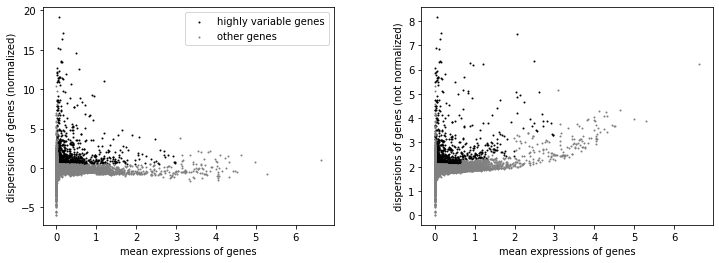

Highly variable genes: 1381


In [29]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata2)

print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

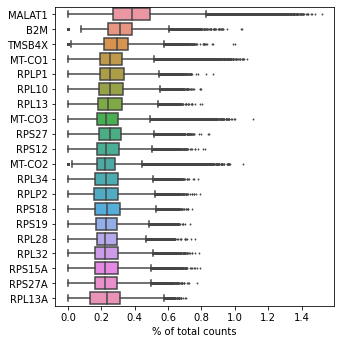

In [30]:
sc.pl.highest_expr_genes(adata2, n_top=20)

In [32]:
malat1 = adata2.var_names.str.startswith(("MALAT1"))
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata2.var_names.str.startswith(("MT-","MTRNR"))
ribo_genes = adata2.var_names.str.startswith(("RPS","RPL"))
remove = np.add(mito_genes,ribo_genes,malat1)
keep = np.invert(remove)

adata2 = adata2[:,keep]

print(adata2.n_obs, adata2.n_vars)

74572 18811


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


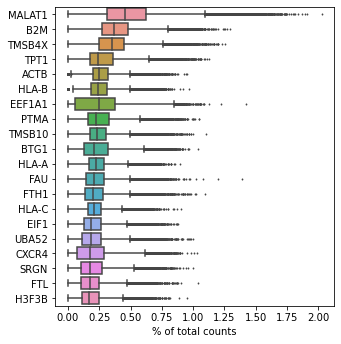

In [33]:
sc.pl.highest_expr_genes(adata2, n_top=20)

In [34]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'dataset')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Highly variable genes intersection: 355
Number of batches where gene is variable:
0    14664
1     3046
2      746
3      355
Name: highly_variable_nbatches, dtype: int64


In [35]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches ==3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 4147
All data var genes: 1381
Overlap: 1318
Variable genes in all batches: 355
Overlap batch instersection and all: 337


In [36]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

1101

In [37]:
# tSNE 
sc.tl.tsne(adata2, n_pcs = 50,n_jobs=20)
# UMAP, first with neighbor calculation
sc.pp.neighbors(adata2, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(adata2)

         Falling back to preprocessing with `sc.pp.pca` and default params.


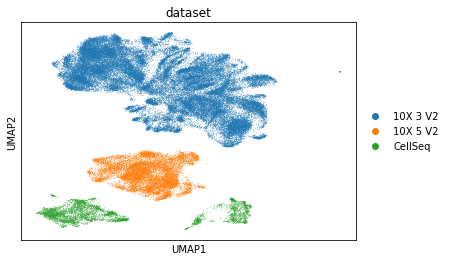

In [39]:
sc.pl.umap(adata2, color='dataset'); plt.show()

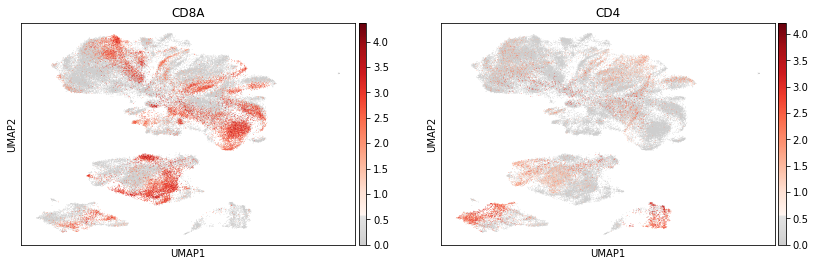

In [40]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata2, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [41]:
adata2.write("/mnt/lugli/SP028_Autoimmunity/h5_files/NotCorrected_T_cell.h5ad")

### Combat

In [42]:
adata_combat = adata2.copy()

In [43]:
sc.pp.combat(adata_combat, key='dataset')

Found 15 genes with zero variance.


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Highly variable genes: 1382


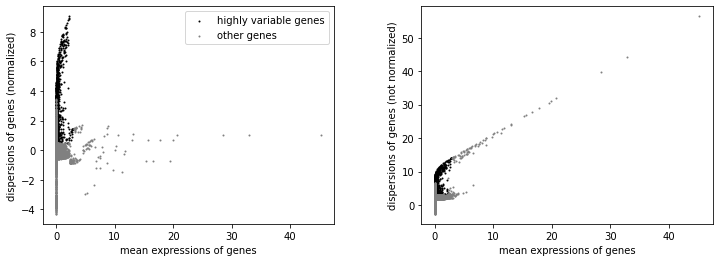

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [44]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)


sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat, n_pcs =30)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat, n_pcs = 30,n_jobs=20)

In [45]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 1381
With combat 1382
Overlap 580
With 2 batches 1101
Overlap 285


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'Combat umap'}, xlabel='UMAP1', ylabel='UMAP2'>

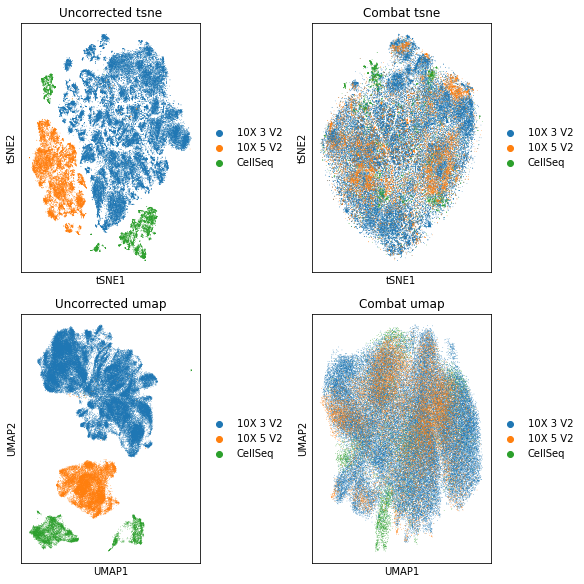

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata2, color="dataset", title="Uncorrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="dataset", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="dataset", title="Uncorrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="dataset", title="Combat umap", ax=axs[1,1], show=False)

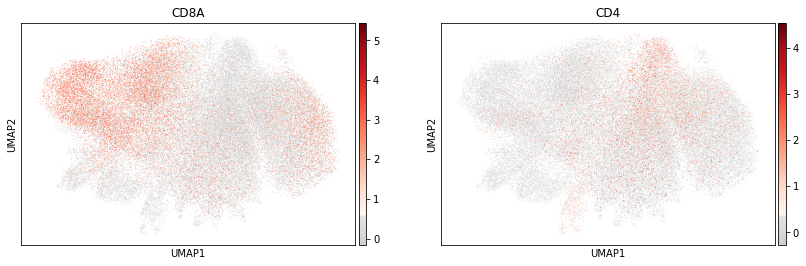

In [48]:
sc.pl.umap(adata_combat, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [49]:
adata_combat.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Combat_T_cell.h5ad")

### Scanorama

In [54]:
adata_scanorama = adata2.copy()

In [56]:
import scanorama
# split per batch into new objects.
#batches = [0,1]
#batches = ['RA','SLE','BC','CRC','Lung','Ovarian','IBD']
batches = ['CellSeq','10X 5 V2','10X 3 V2']
alldata = {}
for batch in batches:
    alldata[batch] = adata_scanorama[adata_scanorama.obs['dataset'] == batch,]

alldata 
#subset the individual dataset to the same variable genes as in MNN-correct.
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama5  = scanorama.integrate_scanpy(adatas, dimred = 50,knn=5)
scanorama20  = scanorama.integrate_scanpy(adatas, dimred = 50,knn=20)
scanorama50  = scanorama.integrate_scanpy(adatas, dimred = 50,knn=50)

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


CellSeq
10X 5 V2
10X 3 V2
Found 1101 genes among all datasets
[[0.         0.26170073 0.07234674]
 [0.         0.         0.35261923]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Found 1101 genes among all datasets
[[0.         0.61980883 0.32630191]
 [0.         0.         0.86296112]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
Found 1101 genes among all datasets
[[0.         0.82729071 0.63513514]
 [0.         0.         0.98841424]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


In [59]:
# make inteo one matrix.
all_s = np.concatenate(scanorama5)
print(all_s.shape)

# add to the AnnData object
adata_scanorama.obsm["SC_K5"] = all_s

(74572, 50)


In [60]:
adata_scanorama

AnnData object with n_obs × n_vars = 74572 × 18811
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_ribo', 'percent_mito', 'dataset'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'gene_id-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'SC_K5'
    obsp: 'distances', 'connectivities'

In [62]:
# tsne and umap
sc.pp.neighbors(adata_scanorama, n_pcs =50, use_rep = "SC_K5")
sc.tl.umap(adata_scanorama)
sc.tl.tsne(adata_scanorama, n_pcs = 50, use_rep = "SC_K5",n_jobs=20)

<AxesSubplot:title={'center':'Scanorama K5 umap'}, xlabel='UMAP1', ylabel='UMAP2'>

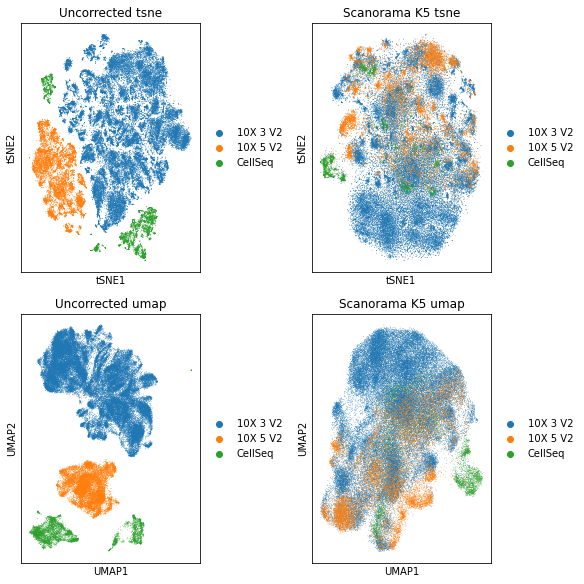

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata2, color="dataset", title="Uncorrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_scanorama, color="dataset", title="Scanorama K5 tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="dataset", title="Uncorrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_scanorama, color="dataset", title="Scanorama K5 umap", ax=axs[1,1], show=False)

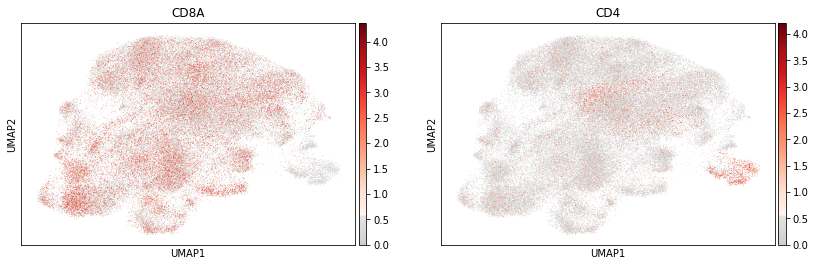

In [70]:
sc.pl.umap(adata_scanorama, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [71]:
# make inteo one matrix.
all_s = np.concatenate(scanorama20)
print(all_s.shape)

# add to the AnnData object
adata_scanorama.obsm["SC_K20"] = all_s
# tsne and umap
sc.pp.neighbors(adata_scanorama, n_pcs =50, use_rep = "SC_K20")
sc.tl.umap(adata_scanorama)
sc.tl.tsne(adata_scanorama, n_pcs = 50, use_rep = "SC_K20",n_jobs=20)

(74572, 50)


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'Scanorama K20 umap'}, xlabel='UMAP1', ylabel='UMAP2'>

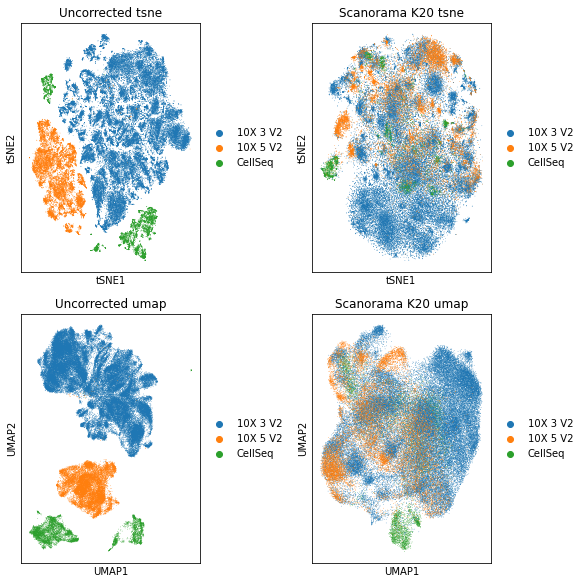

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata2, color="dataset", title="Uncorrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_scanorama, color="dataset", title="Scanorama K20 tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="dataset", title="Uncorrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_scanorama, color="dataset", title="Scanorama K20 umap", ax=axs[1,1], show=False)

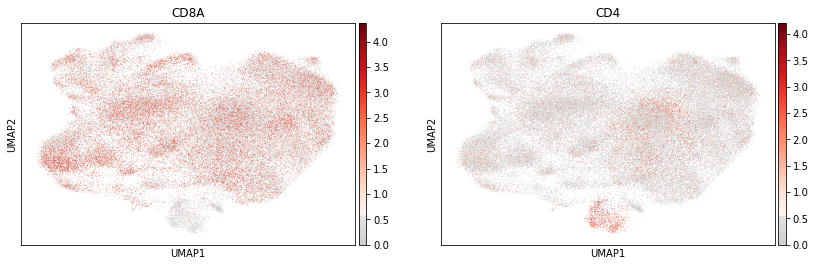

In [73]:
sc.pl.umap(adata_scanorama, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [74]:
# make inteo one matrix.
all_s = np.concatenate(scanorama50)
print(all_s.shape)

# add to the AnnData object
adata_scanorama.obsm["SC_K50"] = all_s
# tsne and umap
sc.pp.neighbors(adata_scanorama, n_pcs =50, use_rep = "SC_K50")
sc.tl.umap(adata_scanorama)
sc.tl.tsne(adata_scanorama, n_pcs = 50, use_rep = "SC_K50",n_jobs=20)

(74572, 50)


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'Scanorama K50 umap'}, xlabel='UMAP1', ylabel='UMAP2'>

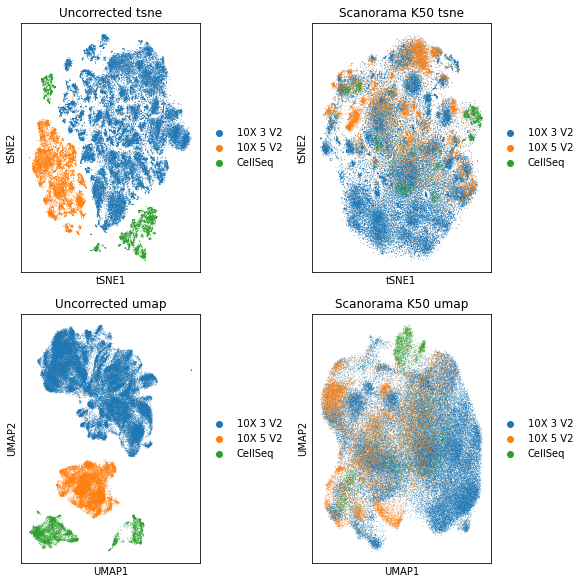

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata2, color="dataset", title="Uncorrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_scanorama, color="dataset", title="Scanorama K50 tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="dataset", title="Uncorrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_scanorama, color="dataset", title="Scanorama K50 umap", ax=axs[1,1], show=False)

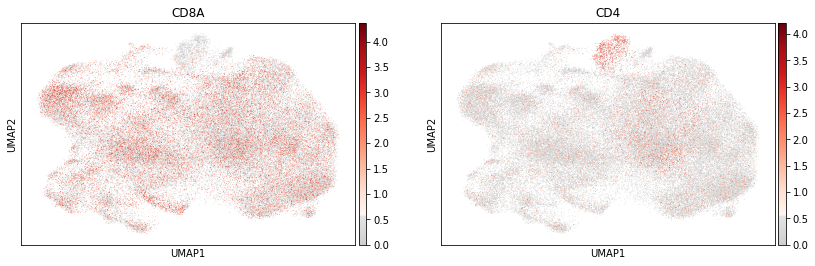

In [76]:
sc.pl.umap(adata_scanorama, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [83]:
adata_scanorama.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Scanorama_T_cell.h5ad")

### Harmony 

In [78]:
import scanpy.external as sce
adata_harmony = adata2.copy()
sce.pp.harmony_integrate(adata_harmony, 'dataset')

2020-10-17 13:04:27,398 - harmonypy - INFO - Iteration 1 of 10
2020-10-17 13:04:58,869 - harmonypy - INFO - Iteration 2 of 10
2020-10-17 13:05:28,213 - harmonypy - INFO - Converged after 2 iterations


Highly variable genes: 1370


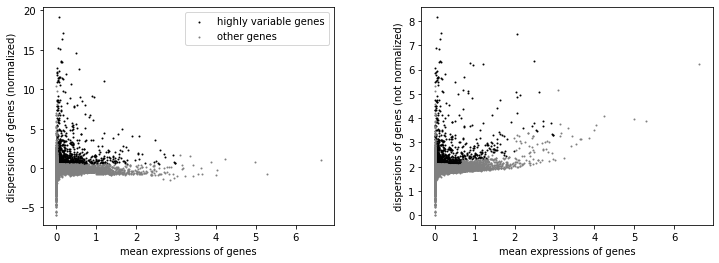

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [79]:
sc.pp.highly_variable_genes(adata_harmony)
print("Highly variable genes: %d"%sum(adata_harmony.var.highly_variable))
sc.pl.highly_variable_genes(adata_harmony)


sc.pp.pca(adata_harmony, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_harmony, n_pcs =30)

sc.tl.umap(adata_harmony)
sc.tl.tsne(adata_harmony, n_pcs = 30,n_jobs=20)

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'Harmony umap'}, xlabel='UMAP1', ylabel='UMAP2'>

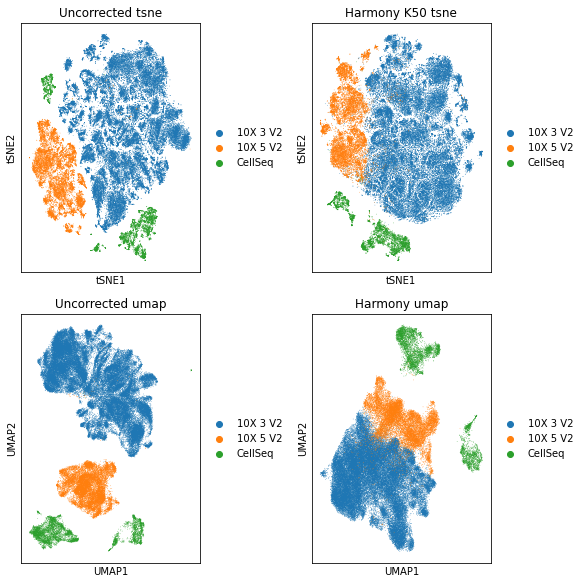

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata2, color="dataset", title="Uncorrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_harmony, color="dataset", title="Harmony K50 tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="dataset", title="Uncorrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_harmony, color="dataset", title="Harmony umap", ax=axs[1,1], show=False)

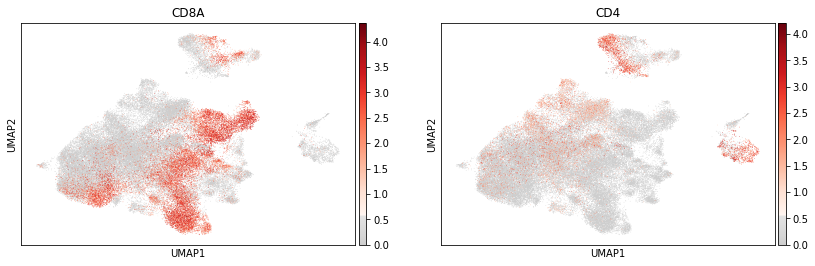

In [81]:
sc.pl.umap(adata_harmony, color=['CD8A','CD4'],color_map=mymap,use_raw=False); plt.show()

In [82]:
adata_harmony.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Harmony_T_cell.h5ad")

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


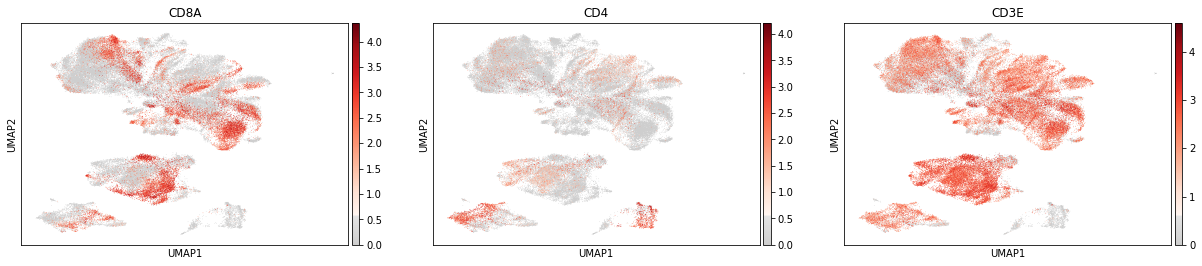

In [10]:
sc.pl.umap(adata2, color=['CD8A','CD4','CD3E'],color_map=mymap,use_raw=False); plt.show()

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters

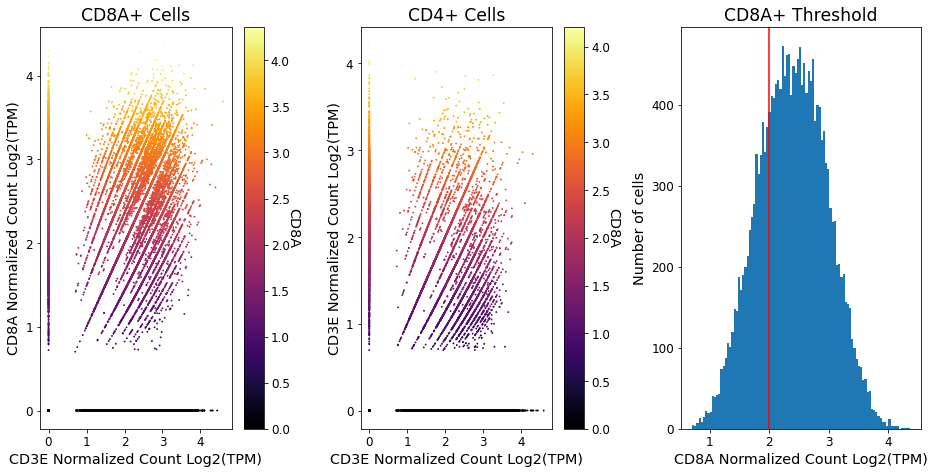

In [3]:
adata2 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/NotCorrected_T_cell.h5ad")
import scprep
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(33/2.54, 17/2.54))

scprep.plot.scatter(x=adata2[:, ['CD3E']].to_df(), y=adata2[:, ['CD8A']].to_df(), c=adata2[:, ['CD8A']].to_df(),  ax=ax1,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD8A Normalized Count Log2(TPM)', legend_title="CD8A", title='CD8A+ Cells')

scprep.plot.scatter(x=adata2[:, ['CD3E']].to_df(), y=adata2[:, ['CD4']].to_df(), c=adata2[:, ['CD4']].to_df(),  ax=ax2,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD3E Normalized Count Log2(TPM)', legend_title="CD8A", title='CD4+ Cells')
scprep.plot.plot_gene_set_expression(adata2[:, ['CD8A']].to_df().loc[adata2[:, ['CD8A']].to_df()['CD8A']>=0.001],xlabel='CD8A Normalized Count Log2(TPM)',cutoff=2,ax=ax3,title="CD8A+ Threshold")

plt.tight_layout()
plt.show()

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters

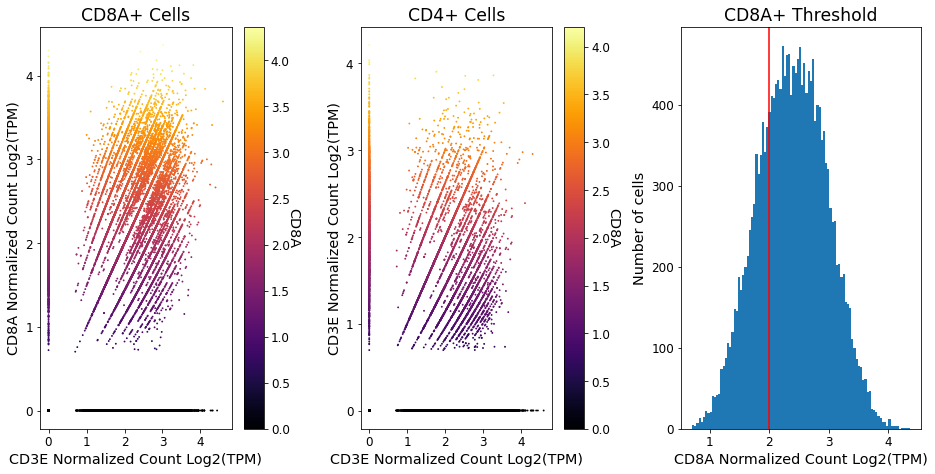

In [92]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(33/2.54, 17/2.54))

scprep.plot.scatter(x=adata_harmony[:, ['CD3E']].to_df(), y=adata_harmony[:, ['CD8A']].to_df(), c=adata_harmony[:, ['CD8A']].to_df(),  ax=ax1,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD8A Normalized Count Log2(TPM)', legend_title="CD8A", title='CD8A+ Cells')

scprep.plot.scatter(x=adata_harmony[:, ['CD3E']].to_df(), y=adata_harmony[:, ['CD4']].to_df(), c=adata_harmony[:, ['CD4']].to_df(),  ax=ax2,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD3E Normalized Count Log2(TPM)', legend_title="CD8A", title='CD4+ Cells')
scprep.plot.plot_gene_set_expression(adata_harmony[:, ['CD8A']].to_df().loc[adata_harmony[:, ['CD8A']].to_df()['CD8A']>=0.001],xlabel='CD8A Normalized Count Log2(TPM)',cutoff=2,ax=ax3,title="CD8A+ Threshold")

plt.tight_layout()
plt.show()

In [11]:
import scanpy.external as sce
adata_magic = adata2
sce.pp.magic(adata_magic,n_jobs=20)

/home/spuccio/.local/lib/python3.8/site-packages/magic/magic.py:471: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 18811-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/spuccio/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/spuccio/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters

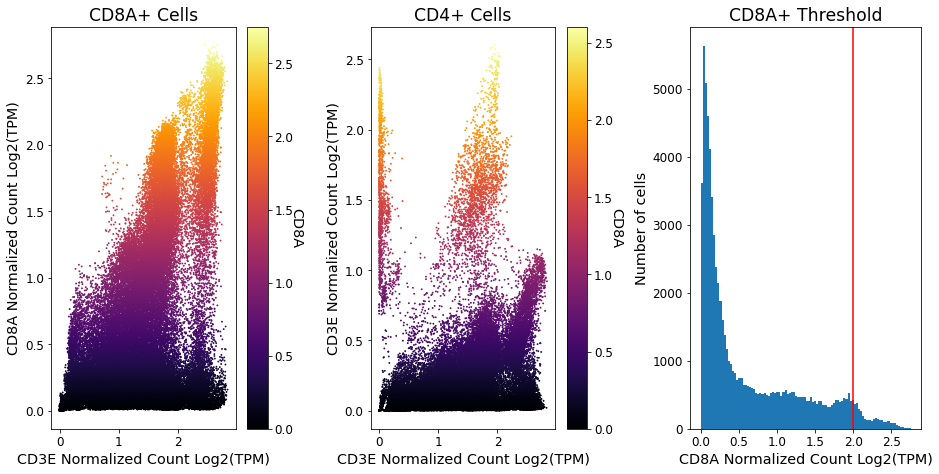

In [12]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(33/2.54, 17/2.54))

scprep.plot.scatter(x=adata_magic[:, ['CD3E']].to_df(), y=adata_magic[:, ['CD8A']].to_df(), c=adata_magic[:, ['CD8A']].to_df(),  ax=ax1,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD8A Normalized Count Log2(TPM)', legend_title="CD8A", title='CD8A+ Cells')

scprep.plot.scatter(x=adata_magic[:, ['CD3E']].to_df(), y=adata_magic[:, ['CD4']].to_df(), c=adata_magic[:, ['CD4']].to_df(),  ax=ax2,
                    xlabel='CD3E Normalized Count Log2(TPM)', ylabel='CD3E Normalized Count Log2(TPM)', legend_title="CD8A", title='CD4+ Cells')
scprep.plot.plot_gene_set_expression(adata_magic[:, ['CD8A']].to_df().loc[adata_magic[:, ['CD8A']].to_df()['CD8A']>=0.001],xlabel='CD8A Normalized Count Log2(TPM)',cutoff=2,ax=ax3,title="CD8A+ Threshold")

plt.tight_layout()
plt.show()

In [9]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)